# Downloading the Dataset


In [9]:
# Dataset location was also found on kaggle, but it just won't download on googlecolab
!wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz -O urban8k.tgz
!tar -xzf urban8k.tgz
!rm urban8k.tgz

--2021-01-17 15:43:38--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘urban8k.tgz’

urban8k.tgz         100%[===================>]   5.61G  7.80MB/s    in 7m 4s   

2021-01-17 15:50:44 (13.5 MB/s) - ‘urban8k.tgz’ saved [6023741708/6023741708]



# Preprocessing the Dataset


In [14]:
import os
import time
import pandas as pd
from PIL import Image
import librosa
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from sklearn import metrics
import matplotlib.pyplot as plt

In [15]:
# Sample Rate is taken to be 22050Hz(it is pretty standard(either this or 20kHz as humans can hear up to around that))
class Feature_Extract:
    def __init__(self, csv_file):
        self.csv_file = csv_file
        self.max_audio_duration = 4
        self.dataset_df = self._create_dataset(csv_file)
    

    @staticmethod
    def _compute_max_pad_length(max_audio_length, sample_rate=22050, n_fft=2048, hop_length=512):
        dummy_file = np.random.random(max_audio_length*sample_rate)
        stft = librosa.stft(dummy_file, n_fft=n_fft, hop_length=hop_length)
        if stft.shape[1] % 2 != 0: #Even length CNN train fast
            return stft.shape[1] + 1
        return stft.shape[1]

    def compute_save_features(self, mode='mfcc', sample_rate=22050,n_fft=2048,hop_length=512,n_mfcc=40,
                        output_path='features',deltas=False):
      
        max_pad = self._compute_max_pad_length(self.max_audio_duration, sample_rate=sample_rate, 
                                               n_fft=n_fft,hop_length=hop_length)
        print('Max Padding = ', max_pad)
        
        if not os.path.exists(output_path):
            print('Creating output folder: ', output_path)
            os.makedirs(output_path)
        else:
            print('Output folder already existed')
            
        print('Saving features in ', output_path)
        features_path = []
        t = time.time()
        i = 0
        for filepath in self.dataset_df['filepath']:
            if i % 100 == 0: #showcasing progress
                print('{} files processed in {}s'.format(i, time.time() - t))
            audio_file, sample_rate = librosa.load(filepath, sr=sample_rate, res_type='kaiser_fast')
            if mode == 'mfcc': #Explained Later as to what MFCC is 
                audio_features = self.compute_mfcc(audio_file, sample_rate, n_fft, hop_length, n_mfcc, deltas)  
            
            audio_features = np.pad(audio_features, pad_width=((0, 0), 
                                                               (0, max_pad - audio_features.shape[1])))
            
            save_path = os.path.join(output_path, filepath.split('/')[-1].replace('wav', 'png'))
            self.save_features(audio_features, save_path)
            features_path.append(save_path)
            i+=1
        self.dataset_df['features_path'] = features_path
        return self.dataset_df
    
    @staticmethod
    def save_features(audio_features, filepath):
        image = Image.fromarray(audio_features)
        image = image.convert("L")# grayscale conversion
        image.save(filepath)

    @staticmethod
    def _create_dataset(csv_file):
        dataset_df = pd.read_csv(csv_file)
        filepaths = []
        for i, row in dataset_df.iterrows():
            filepaths.append(os.path.join('UrbanSound8K/audio', 'fold'+str(row['fold']), row['slice_file_name']))
        dataset_df['filepath'] = filepaths
        return dataset_df

    @staticmethod
    def compute_mfcc(audio_file, sample_rate, n_fft, hop_length, n_mfcc, deltas=False):
        mfccs = librosa.feature.mfcc(audio_file,
                                    sr=sample_rate, 
                                    n_fft=n_fft,
                                    n_mfcc=n_mfcc,
                                    )
        # Changing mode to nearest
        if deltas:
          delta_mfccs = librosa.feature.delta(mfccs, mode='nearest')
          delta2_mfccs = librosa.feature.delta(mfccs, order=2, mode='nearest')
          return np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
        return mfccs

In [16]:
fe = Feature_Extract('UrbanSound8K/metadata/UrbanSound8K.csv')

In [17]:
dataset_df = fe.compute_save_features(mode='mfcc', n_mfcc=13, output_path='features_mfcc', deltas=True)

Max Padding =  174
Creating output folder:  features_mfcc
Saving features in  features_mfcc
0 files processed in 0.00021839141845703125s
100 files processed in 17.933808088302612s
200 files processed in 33.04144811630249s
300 files processed in 51.93270707130432s
400 files processed in 66.79976511001587s
500 files processed in 82.28389573097229s
600 files processed in 97.22486662864685s
700 files processed in 113.9773519039154s
800 files processed in 134.31610822677612s
900 files processed in 150.23560976982117s
1000 files processed in 165.15760111808777s
1100 files processed in 179.33877611160278s
1200 files processed in 194.72031593322754s
1300 files processed in 210.08374190330505s
1400 files processed in 226.51639223098755s
1500 files processed in 239.21866917610168s
1600 files processed in 255.67073917388916s
1700 files processed in 271.05540347099304s
1800 files processed in 289.7439196109772s
1900 files processed in 306.62942576408386s
2000 files processed in 323.88389253616333s

In [18]:
dataset_df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,filepath,features_path
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,UrbanSound8K/audio/fold5/100032-3-0-0.wav,features_mfcc/100032-3-0-0.png
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-117.wav,features_mfcc/100263-2-0-117.png
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-121.wav,features_mfcc/100263-2-0-121.png
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-126.wav,features_mfcc/100263-2-0-126.png
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-137.wav,features_mfcc/100263-2-0-137.png


# Data Visualization

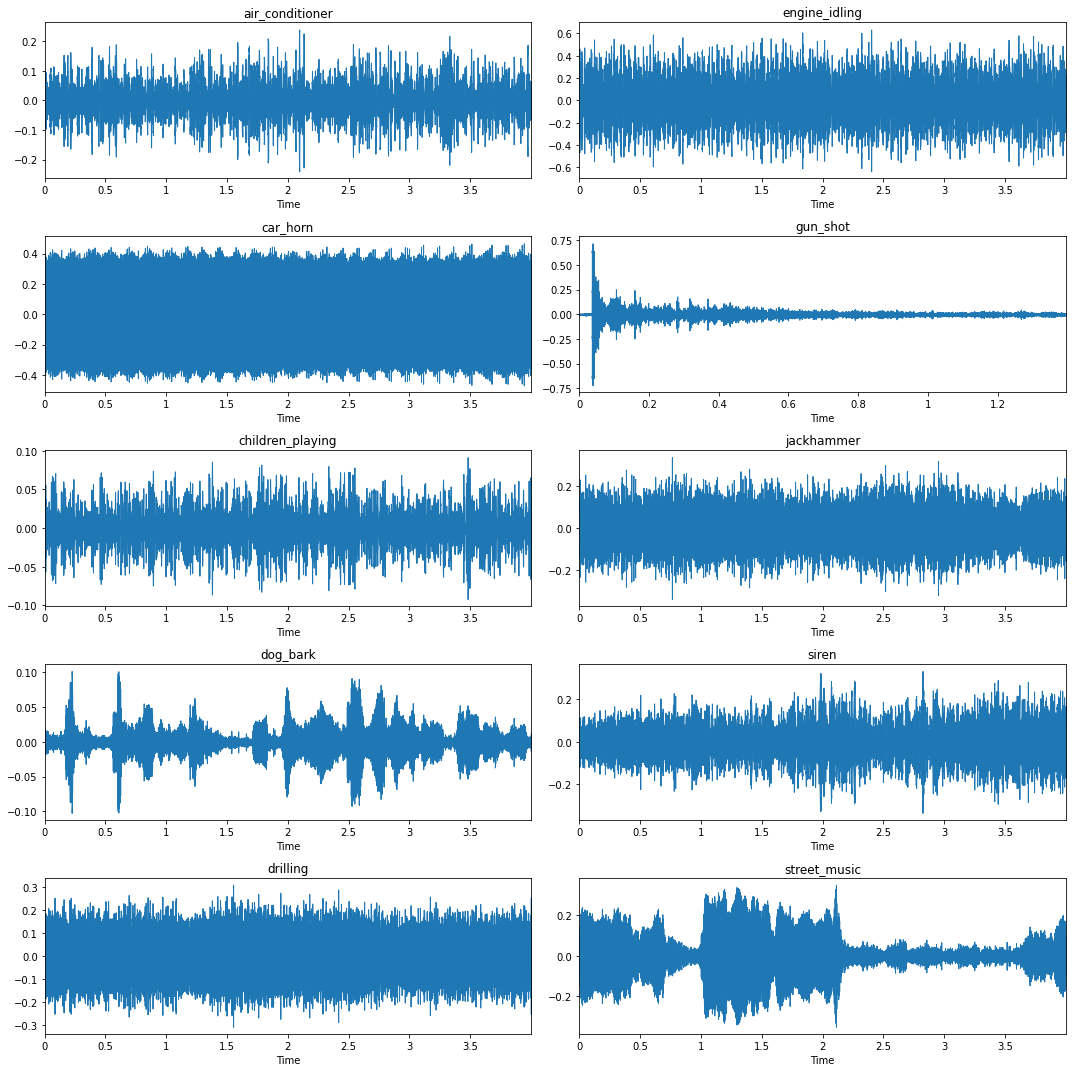

In [19]:
# Randomly select one sample of each class
random_samples = dataset_df.groupby('class').sample(1)
audio_samples, labels = random_samples['filepath'].tolist(), random_samples['class'].tolist()

# Visualize the waveforms
fig, axs = plt.subplots(5, 2, figsize=(15,15))
index = 0
for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        librosa.display.waveplot(audio_file, sample_rate, ax=axs[row][col])
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1
fig.tight_layout()

# MFCC Visualization

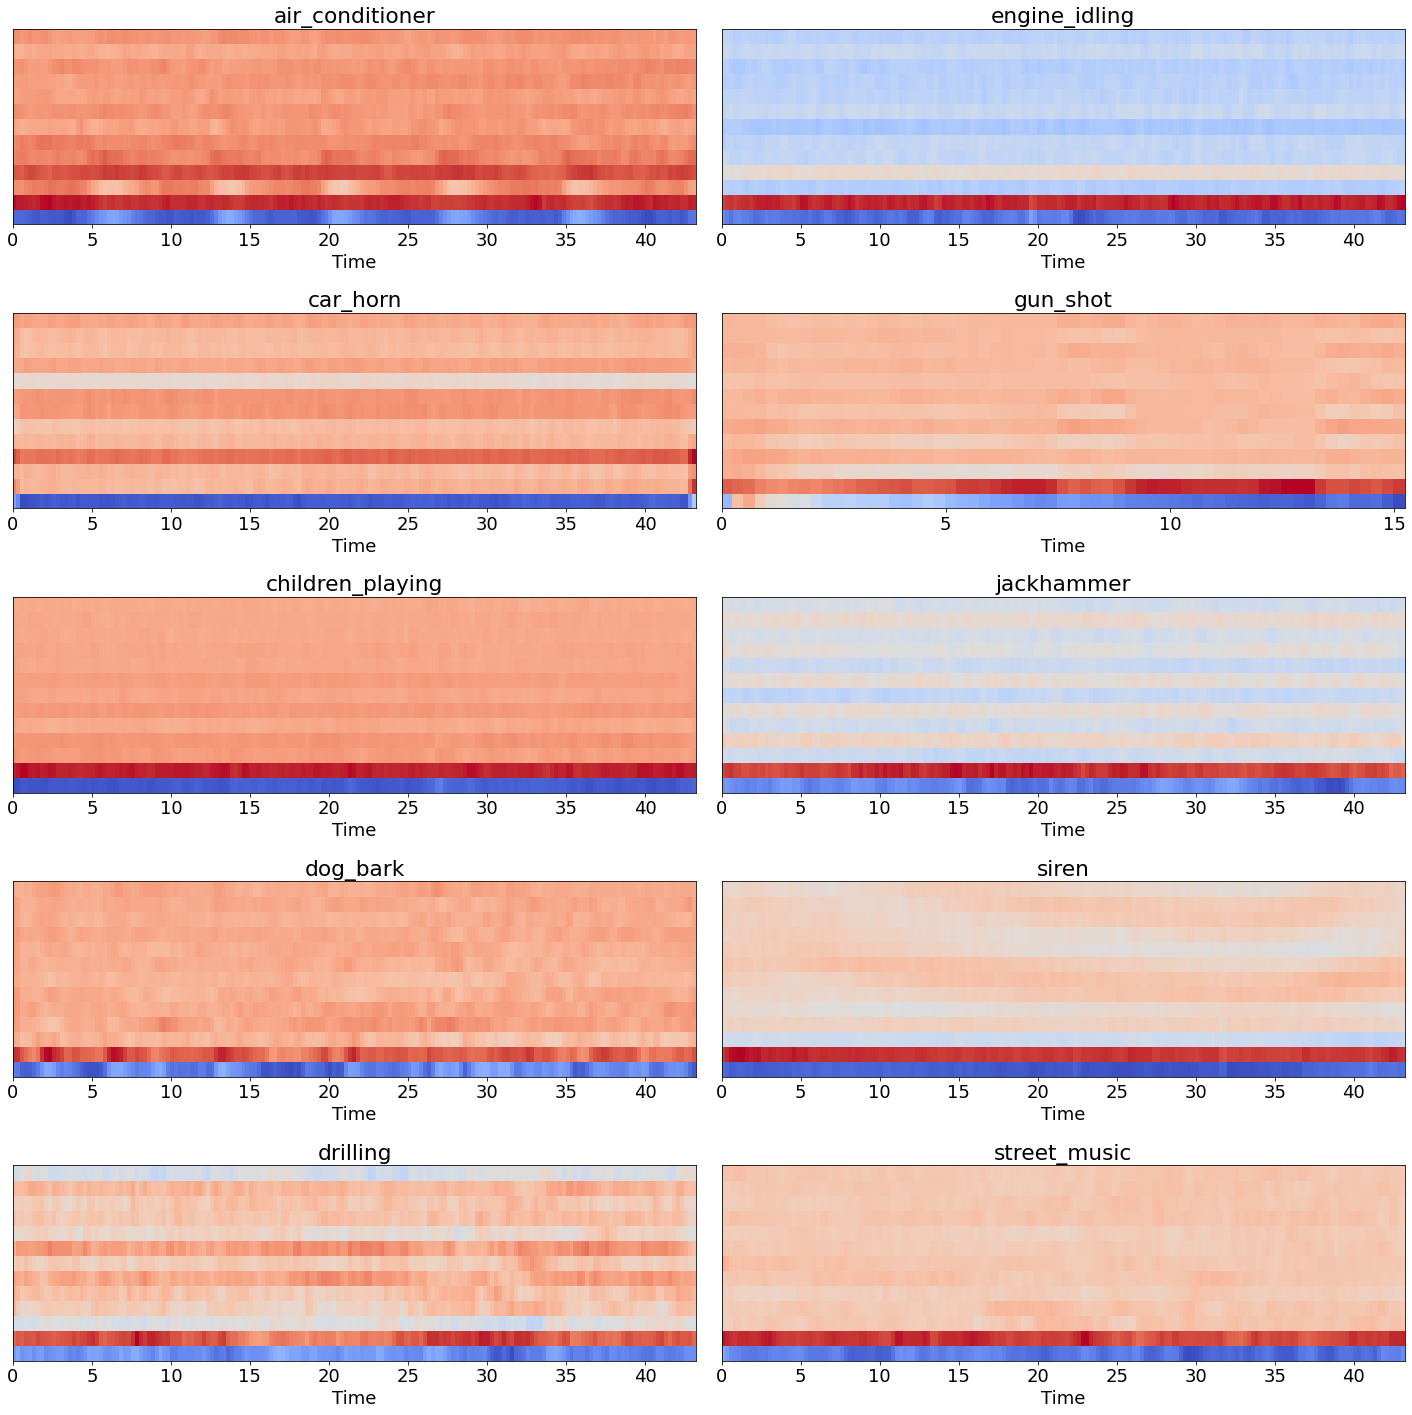

In [71]:
#MFCC stands for Mel-Frequency Cepstral Coefficients
#It is my go-to method to process audio signals and generate features as- 
#-input for Neural Networks.
n_fft = 2048
hop_length = 512
fig, axs = plt.subplots(5, 2, figsize=(20,20))
index = 0
n_s = 4
for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        mfccs = librosa.feature.mfcc(audio_file,sr=sample_rate, 
                                    n_fft=n_fft,n_mfcc=13)
        librosa.display.specshow(mfccs, sr=n_fft, hop_length=hop_length, 
                             x_axis="time", ax=axs[row][col])
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1
fig.tight_layout()



In [38]:
#Unziping the features
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1BU2B5EcbfyGBIOkB5YC44hpzPpuqw43H' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1BU2B5EcbfyGBIOkB5YC44hpzPpuqw43H" -O features_mfcc.zip && rm -rf /tmp/cookies.txt
!unzip -q features_mfcc.zip
!rm features_mfcc.zip

--2021-01-17 16:27:13--  https://docs.google.com/uc?export=download&confirm=ggI5&id=1BU2B5EcbfyGBIOkB5YC44hpzPpuqw43H
Resolving docs.google.com (docs.google.com)... 142.250.73.238, 2607:f8b0:4004:808::200e
Connecting to docs.google.com (docs.google.com)|142.250.73.238|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-2o-docs.googleusercontent.com/docs/securesc/d6qo2k1mohvcqldqhhvnavd246kj8c8a/65gt5ln1bhccgleakt80v2k1a4bglif3/1610900775000/12555612686504083087/04904034784320387772Z/1BU2B5EcbfyGBIOkB5YC44hpzPpuqw43H?e=download [following]
--2021-01-17 16:27:13--  https://doc-0c-2o-docs.googleusercontent.com/docs/securesc/d6qo2k1mohvcqldqhhvnavd246kj8c8a/65gt5ln1bhccgleakt80v2k1a4bglif3/1610900775000/12555612686504083087/04904034784320387772Z/1BU2B5EcbfyGBIOkB5YC44hpzPpuqw43H?e=download
Resolving doc-0c-2o-docs.googleusercontent.com (doc-0c-2o-docs.googleusercontent.com)... 172.217.164.161, 2607:f8b0:4004:815::2001
Connecting to doc-

In [39]:
#Download dataset.json file
!wget --no-check-certificate "https://docs.google.com/uc?export=download&id=1pzSvGYaBXghLQFTZxlSex-Ts3T4B0X4C" -O dataset.json

--2021-01-17 16:27:24--  https://docs.google.com/uc?export=download&id=1pzSvGYaBXghLQFTZxlSex-Ts3T4B0X4C
Resolving docs.google.com (docs.google.com)... 142.250.73.238, 2607:f8b0:4004:814::200e
Connecting to docs.google.com (docs.google.com)|142.250.73.238|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-1k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jdf32bjdc7epomv8b7d2ol8k6v6059vq/1610900775000/12555612686504083087/*/1pzSvGYaBXghLQFTZxlSex-Ts3T4B0X4C?e=download [following]
--2021-01-17 16:27:25--  https://doc-0s-1k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jdf32bjdc7epomv8b7d2ol8k6v6059vq/1610900775000/12555612686504083087/*/1pzSvGYaBXghLQFTZxlSex-Ts3T4B0X4C?e=download
Resolving doc-0s-1k-docs.googleusercontent.com (doc-0s-1k-docs.googleusercontent.com)... 172.217.164.161, 2607:f8b0:4004:815::2001
Connecting to doc-0s-1k-docs.googleusercontent.com (doc-0s-1k-docs.goog

In [40]:
dataset = pd.read_json('dataset.json')

In [41]:
dataset['features'] = [np.asarray(np.load(feature_path)) for feature_path in dataset['features_path']]

In [43]:
dataset['labels_categorical'] = [to_categorical(label, 10) for label in dataset['classID']]

In [44]:
dataset.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,filepath,features_path,features,labels_categorical
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,UrbanSound8K/audio/fold5/100032-3-0-0.wav,features_mfcc/100032-3-0-0.npy,"[[[-306.77255], [-177.59209], [-99.13616], [-6...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-117.wav,features_mfcc/100263-2-0-117.npy,"[[[-457.69534], [-451.0248], [-450.68613], [-4...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-121.wav,features_mfcc/100263-2-0-121.npy,"[[[-468.0367], [-467.42264], [-481.04654], [-4...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-126.wav,features_mfcc/100263-2-0-126.npy,"[[[-422.42215], [-411.9085], [-409.46243], [-4...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-137.wav,features_mfcc/100263-2-0-137.npy,"[[[-438.10162], [-434.47787], [-443.3284], [-4...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


# Splitting the Dataset

In [47]:
# Adding one dimension for the channel
X = np.array(dataset['features'].tolist())
y = np.array(dataset['labels_categorical'].tolist())


X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.20, 
                                                    random_state=124, stratify=y)

X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.4, 
                                                random_state=124, stratify=Y_test)

print(X_train.shape, X_val.shape, X_test.shape)

(6985, 39, 174, 1) (699, 39, 174, 1) (1048, 39, 174, 1)


In [54]:
#model Creation
def create_model(num_classes=10, input_shape=None, dropout_ratio=None):
    model = Sequential()
    if input_shape is None:
        model.add(Input(shape=(None, None, 1)))
    else:
        model.add(Input(shape=input_shape))
    model.add(Conv2D(filters=32, kernel_size=(2, 4), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 3)))
    model.add(Conv2D(filters=64, kernel_size=(2, 4), activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=128, kernel_size=(2, 4), activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=128, kernel_size=(2, 4), activation='relu'))
    model.add(GlobalAveragePooling2D())
    if dropout_ratio is not None:
        model.add(Dropout(dropout_ratio))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [81]:
fcn_model = create_model(input_shape=X_train.shape[1:])

In [82]:
fcn_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
fcn_model.summary() # we have a decent. number of parameters to train

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 38, 171, 32)       288       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 19, 57, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 18, 54, 64)        16448     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 9, 27, 64)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 8, 24, 128)        65664     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 4, 12, 128)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 3, 9, 128)        

In [83]:
!mkdir saved_models

mkdir: cannot create directory ‘saved_models’: File exists


In [84]:
def train_model(model, X_train, Y_train, X_val, Y_val, epochs, batch_size, callbacks):
    model.fit(X_train, Y_train, 
              batch_size=batch_size, epochs=epochs, 
              validation_data=(X_val, Y_val), 
              callbacks=callbacks, verbose=1)
    return model

In [85]:
checkpointer = ModelCheckpoint(filepath='saved_models/best_model.hdf5',
                               monitor='val_accuracy', verbose=1, save_best_only=True)
callbacks = [checkpointer]

# Hyperparameters
epochs = 128
batch_size = 256

In [86]:
# Training
model = train_model(model=fcn_model,X_train=X_train,
                    X_val=X_val,Y_train=Y_train,
                    Y_val=Y_val,epochs=epochs,
                    batch_size=batch_size,
                    callbacks=callbacks)

Epoch 1/128
28/28 [==============================] - 2s 55ms/step - loss: 2.7424 - accuracy: 0.1892 - val_loss: 1.6073 - val_accuracy: 0.4363

Epoch 00001: val_accuracy improved from -inf to 0.43634, saving model to saved_models/best_model.hdf5
Epoch 2/128
28/28 [==============================] - 1s 42ms/step - loss: 1.4902 - accuracy: 0.4526 - val_loss: 1.3921 - val_accuracy: 0.4921

Epoch 00002: val_accuracy improved from 0.43634 to 0.49213, saving model to saved_models/best_model.hdf5
Epoch 3/128
28/28 [==============================] - 1s 41ms/step - loss: 1.2515 - accuracy: 0.5605 - val_loss: 1.1508 - val_accuracy: 0.6223

Epoch 00003: val_accuracy improved from 0.49213 to 0.62232, saving model to saved_models/best_model.hdf5
Epoch 4/128
28/28 [==============================] - 1s 42ms/step - loss: 1.0620 - accuracy: 0.6441 - val_loss: 1.0768 - val_accuracy: 0.6323

Epoch 00004: val_accuracy improved from 0.62232 to 0.63233, saving model to saved_models/best_model.hdf5
Epoch 5/128

In [87]:
# Load the best model
best_model = load_model('saved_models/best_model.hdf5')

In [88]:
# Evaluation
score = best_model.evaluate(X_train, Y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = best_model.evaluate(X_val, Y_val, verbose=0)
print("Validation Accuracy: ", score[1])

score = best_model.evaluate(X_test, Y_test, verbose=0)
print("Testing Accuracy: ", score[1])
#Accuracy gained seems decent. So, we can move to plotting the output

Training Accuracy:  0.9985683560371399
Validation Accuracy:  0.9313304424285889
Testing Accuracy:  0.9265267252922058
